# Implementation of Phrase List Feature

We explore ways in which we can add medical terms for better detection by the speech-to-text system. 

In particular, we leverage Azure Text Analytics for Health to extract medical entities of high confidence that was missed out in detection. Then, we dynamically add these to Phrase List based on detected context of conversation.

## Authenticate Client

In [1]:
import os
from dotenv import load_dotenv
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

load_dotenv()
AZURE_API_KEY = os.getenv("AZURE_API_KEY")
AZURE_API_ENDPOINT = os.getenv("AZURE_API_ENDPOINT")

def authenticate_client():
    ta_credential = AzureKeyCredential(AZURE_API_KEY)
    text_analytics_client = TextAnalyticsClient(endpoint=AZURE_API_ENDPOINT, credential=ta_credential)
    return text_analytics_client

client = authenticate_client()

## Extract Medical Entities

In [4]:
# Read word list
with open("../data/eval/word_list.txt", "r") as file:
    # Read all lines and strip newline characters
    word_list = [line.strip() for line in file]

# Display the list of words
print(word_list)

['start', 'sir', 'whatd', 'mention', 'watery', 'left', 'side', 'come', 'go', 'example', 'towards', 'sweats', 'stopped', 'vomit', 'takeaway', 'fit', 'question', 'way', 'er', 'story', 'stool', 'fever', 'little', 'wondered', 'dioralyte', 'helps', 'eh', 'work', 'actually', 'quite', 'keen', 'next', 'three', 'days', 'infection', 'clears', 'system', 'take', 'time', 'rest', 'admit', 'caused', 'hey', 'maybe', 'makes', 'yknow', 'blood', 'ate', 'athsma', 'use', 'problem', 'certain', 'get', 'steroid', 'havent', 'seen', 'resmarize', 'sorry', 'said', 'allergies', 'sarah', 'piriton', 'eczema', 'cu', 'types', 'antihistamines', 'fexofenadine', 'cant', 'shower', 'symptoms', 'appeared', 'itching', 'arm', 'pretty', 'weekend', 'cannot', 'itchy', 'disease', 'arms', 'thank', 'mid', 'day', 'worries', 'headache', 'lymes', 'twice', 'mean', 'concern', 'lot', 'let', 'maam', 'difficulties', 'breathings', 'thyroid', 'meant', 'hope', 'puts', 'mind', 'ease', 'triggering', 'terms', 'trying', 'co', 'codamol', 'hows', '

In [5]:
# Use the Azure Healthcare NER API to analyze the document
documents = [" ".join(word_list)]
poller = client.begin_analyze_healthcare_entities(documents)
results = poller.result()

# Process the results
entities = []

for result in results:
    if not result.is_error:
        for entity in result.entities:
            entity_info = {
                "text": entity.text,
                "category": entity.category,
                "subcategory": entity.subcategory,
                "confidence_score": entity.confidence_score,
                "normalized_text": entity.normalized_text
            }
            entities.append(entity_info)
    else:
        print(f"Error: {result.error.code} - {result.error.message}")

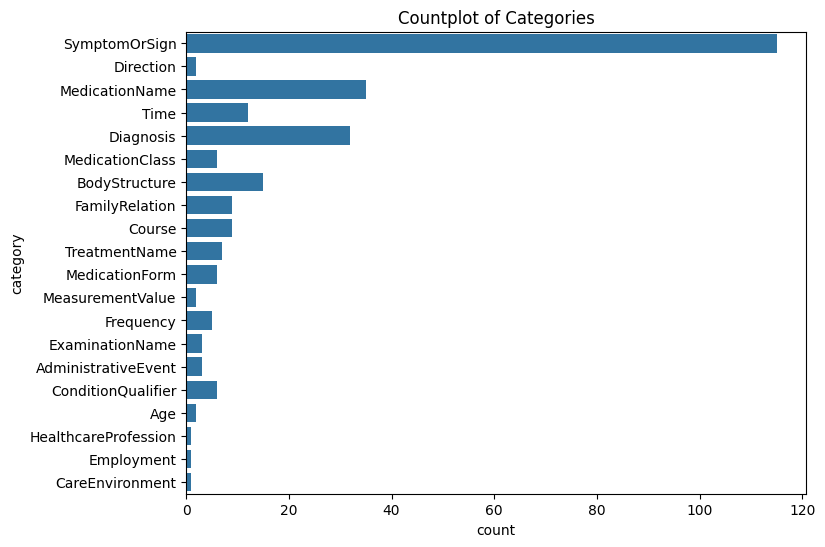

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

entities_df = pd.DataFrame(entities)

plt.figure(figsize=(8,6))
sns.countplot(y='category', data=entities_df)
plt.title('Countplot of Categories')
plt.show()

In [7]:
len(entities_df)

272

## Generating Headers Using SOAP Framework

Suggested context classes based on SOAP framework:
- Patient Subjective Information
- Objective Information (Examinations and Findings)
- Doctor's Assessment
- Treatment Plan

We experiment using these SOAP headers to give a "fixed" chapter title for summarization purposes.

In [42]:
import pandas as pd

# Initialize file for transcriptions
transcriptions_df = pd.read_csv("../data/eval/primock57_speechsdk_realtime.csv")
transcriptions_df.head()

,id,transcription,reference,mer,wil,wip,wer
0,day1_consultation01_doctor,Hello. Hi. Yeah. OK. Hello. Good morning. How ...,"Hello? Hi. Um, should we start? Yeah, okay. He...",0.204522,0.289805,0.710195,0.209253
1,day1_consultation01_patient,"Hello, how are you? Hi, I just had some diarrh...","Hello, how are you? Oh hey, um, I've just had ...",0.200772,0.260102,0.739898,0.204724
2,day1_consultation02_doctor,"Hello. Yes, I think it's a bit better. It's a ...",Hello? Uh uh yes. I think. It's a bit better. ...,0.140334,0.180209,0.819791,0.143143
3,day1_consultation02_patient,"Hello. Can you hear me well? OK. Yes, so it's ...","Hello. Can you hear me well? OK. Yes. So, it's...",0.132124,0.176073,0.823927,0.133858
4,day1_consultation03_doctor,"Hello. Hello there, it's Doctor Steve here. Ho...",Hello? Hello there. It's uh Doctor here. How c...,0.164768,0.227154,0.772846,0.168459


In [12]:
# for each transcription, get the headings for contexts
import os
from dotenv import load_dotenv
from openai import AzureOpenAI

# Set up Azure OpenAI client

load_dotenv()
AZURE_OPENAI_KEY = os.getenv("AZURE_OPENAI_KEY")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")

openai_client = AzureOpenAI(
    api_version="2024-02-01", # Make sure to use the correct API version
    api_key=AZURE_OPENAI_KEY,
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
)

In [17]:
# Function to generate SOAP headers using Azure OpenAI
def generate_soap_titles(text):
    # The prompt asks for SOAP headers based on the provided transcript
    messages = [
        {
            "role": "system",
            "content": "You are an assistant that generates concise headers for transcripts. Your task is to analyze the text and create relevant titles based on context changes."

        },
        {
            "role": "user",
            "content": (
                f"Generate concise chapter titles for the following medical consultation transcript out of the following options based on the SOAP framework for medical notes: ['Patient Subjective Information', 'Objective Information (Examinations and Findings)', 'Doctor's Assessment', 'Treatment Plan']:\n\n{text}\n\n."
                "Each title should reflect the appropriate change in context."
                "After generating the titles, update them into the full transcript, with every single word, at the appropriate locations. Only show the full transcript with titles."
                "Here is a sample transcript from a medical consultation, the format should be something like this:\n\n"
                
                "1. Patient Subjective Information"
                "You mentioned experiencing persistent headaches for the past two weeks, describing the pain as throbbing and located around your temples. You rated the pain as moderate but worsening, especially during periods of stress. You have no other associated symptoms like nausea or sensitivity to light. There's a family history of migraines, specifically with your mother, and you're not currently taking any prescription medications aside from over-the-counter pain relief."

                "2. Objective Information (Examinations and Findings)"
                "Your vital signs are normal, with a blood pressure of 120/80 mmHg and a heart rate of 72 beats per minute. The neurological exam revealed no abnormalities—your reflexes and coordination are intact, and there’s no indication of infection in your ears, throat, or sinuses. I’m going to schedule a CT scan to rule out any structural causes of the headache, just to be thorough."

                "3. Doctor's Assessment"
                "Based on your symptoms and the examination, it seems like you're experiencing tension headaches, likely stress-induced. Given your family history of migraines, we can’t rule out that possibility, so further evaluation might be needed. For now, I’m leaning toward a diagnosis of tension headaches."

                "4. Treatment Plan"
                "To manage the headaches, I recommend keeping a diary to track any patterns or potential triggers, such as specific stressors or dietary changes. You can continue using over-the-counter NSAIDs, like ibuprofen, as needed for pain relief. I’ll also refer you to a neurologist for further evaluation regarding migraines. In the meantime, reducing stress through relaxation techniques like deep breathing or mindfulness may help. Let’s schedule a follow-up in two weeks to reassess how things are progressing."
            )
        }

    ]

    # Request to the Azure OpenAI API using chat completions
    completion = openai_client.chat.completions.create(
        model="gpt-4o-mini",  # Replace with your Azure GPT model deployment name
        messages=messages,
        #max_tokens=200,  # Limit tokens for a concise response
        temperature=0.7,  # Adjust to control creativity level
        n=1,  # Number of responses
    )

    # Extract and return the generated titles
    titles = completion.choices[0].message.content.strip()
    return titles

In [18]:
# Generate a formatted transcript with SOAP titles based on the transcribed text
formatted_text = generate_soap_titles(transcriptions_df['transcription'].iloc[0]) # Doctor
print(formatted_text)

1. Patient Subjective Information  
Hello. Hi. Yeah. OK. Hello. Good morning. How can I help you this morning? Yeah, I'm sorry to hear that. And when you say diarrhoea, what do you mean by diarrhea? Do you mean you're going to the toilet more often or are your stools more loose? OK. And how many times a day are you going, let's say over the last couple of days? 6-7 times a day and you mentioned this mainly water tree. Have you noticed any other things like blood in your stools? OK. And you mentioned you've had some pain in your tummy as well. Whereabouts is the pain exactly? One side. And what side is that? That's right. OK. And can you describe the pain to me? OK. And there's a pain. Is that is it there all the time or does it come and go? Does the pain move anywhere else because on between your back? OK, fine. And you mentioned you've been feeling quite weak and shaky as well. What do you mean by shaky? Do you mean you've been having, have you been feeling feverish, for example? Meas

In [19]:
# Filter out doctors' transcripts only
doctor_transcriptions_df = transcriptions_df[transcriptions_df["id"].str.contains("doctor")].copy()
doctor_transcriptions_df.head()

,id,transcription,reference,mer,wil,wip,wer
0,day1_consultation01_doctor,Hello. Hi. Yeah. OK. Hello. Good morning. How ...,"Hello? Hi. Um, should we start? Yeah, okay. He...",0.204522,0.289805,0.710195,0.209253
2,day1_consultation02_doctor,"Hello. Yes, I think it's a bit better. It's a ...",Hello? Uh uh yes. I think. It's a bit better. ...,0.140334,0.180209,0.819791,0.143143
4,day1_consultation03_doctor,"Hello. Hello there, it's Doctor Steve here. Ho...",Hello? Hello there. It's uh Doctor here. How c...,0.164768,0.227154,0.772846,0.168459
6,day1_consultation04_doctor,"Alex. Oh, hello. Hey, can you hear me? OK, Gra...","Alex. Ohh. Hello? Hi, can you hear me? OK grea...",0.168539,0.234423,0.765577,0.174757
8,day1_consultation05_doctor,"Hello. Good morning, Kim. How can I help you t...","Hello? . Good morning, Tim. Um, how can I help...",0.181400,0.250073,0.749927,0.183940


In [20]:
# Generate titles for doctors' transcripts only
from tqdm import tqdm
tqdm.pandas()

doctor_transcriptions_df["titled_transcription"] = doctor_transcriptions_df["transcription"].progress_apply(lambda x: generate_soap_titles(x))
doctor_transcriptions_df["titled_transcription"].head()

100%|██████████| 57/57 [06:34<00:00,  6.92s/it]


0    1. Patient Subjective Information  \nHello. Hi...
2    1. Patient Subjective Information  \nHello. Ye...
4    1. Patient Subjective Information  \nHello. He...
6    1. Patient Subjective Information  \nAlex. Oh,...
8    1. Patient Subjective Information  \nHello. Go...
Name: titled_transcription, dtype: object

In [71]:
print(doctor_transcriptions_df["titled_transcription"].iloc[0])

1. Patient Subjective Information  
Hello. Hi. Yeah. OK. Hello. Good morning. How can I help you this morning? Yeah, I'm sorry to hear that. And when you say diarrhoea, what do you mean by diarrhea? Do you mean you're going to the toilet more often or are your stools more loose? OK. And how many times a day are you going, let's say over the last couple of days? 6-7 times a day and you mentioned this mainly water tree. Have you noticed any other things like blood in your stools? OK. And you mentioned you've had some pain in your tummy as well. Whereabouts is the pain exactly? One side. And what side is that? That's right. OK. And can you describe the pain to me? OK. And there's a pain. Is that is it there all the time or does it come and go? Does the pain move anywhere else because on between your back? OK, fine. And you mentioned you've been feeling quite weak and shaky as well. What do you mean by shaky? Do you mean you've been having, have you been feeling feverish, for example? Meas

In [39]:
# Save locally
# doctor_transcriptions_df.to_csv("../data/eval/doctor_soap_transcriptions.csv", index=False)

# Proposed Entities-Context Mapping

We are concerned with obtaining a subset of entities for each context to innovate a scalable solution in case the number of phrases exceeded the required limit for using Speech SDK. 

We implement the following mappings based on contextual knowledge:
- Patient Subjective Information: SymptomOrSign, MedicationClass, MedicationForm
- Objective Information (Examinations and Findings): SymptomOrSign, MedicationClass, MedicationForm
- Doctor's Assessment: SymptomOrSign, Diagnosis, MedicationClass, MedicationForm, ExaminationName
- Treatment Plan: TreatmentName, ExaminationName, MedicationClass, MedicationForm, AdministrativeEvent

In [8]:
subjective_and_objective_list = entities_df[entities_df['category'].isin(['SymptomOrSign', 'MedicationClass', 'MedicationForm'])]["text"].tolist()
assessment_list = entities_df[entities_df['category'].isin(['SymptomOrSign', 'Diagnosis', 'MedicationClass', 'MedicationForm', 'ExaminationName'])]["text"].tolist()
treatment_list = entities_df[entities_df['category'].isin(['TreatmentName', 'ExaminationName', 'MedicationClass', 'MedicationForm', 'AdministrativeEvent'])]["text"].tolist()

## Demo

In [9]:
# OpenAI function to generate SOAP title
def classify_context(text):
    messages = [
        {
            "role": "system",
            "content": "You are an assistant that generates concise headers for transcripts. Your task is to analyze the text and assign a relevant title to the text."

        },
        {
            "role": "user",
            "content": (
                f"Assign an appropriate title for the following text chunk from part of a medical consultation transcript out of the following options based on the SOAP framework for medical notes: ['Patient Subjective Information', 'Objective Information (Examinations and Findings)', 'Doctor's Assessment', 'Treatment Plan']:\n\n{text}\n\n."
                "Here are some sample text chunks from a medical consultation:\n\n"
                
                "Input text: You mentioned experiencing persistent headaches for the past two weeks, describing the pain as throbbing and located around your temples. You rated the pain as moderate but worsening, especially during periods of stress. You have no other associated symptoms like nausea or sensitivity to light. There's a family history of migraines, specifically with your mother, and you're not currently taking any prescription medications aside from over-the-counter pain relief."
                "Output: Patient Subjective Information"

                "Input text: Your vital signs are normal, with a blood pressure of 120/80 mmHg and a heart rate of 72 beats per minute. The neurological exam revealed no abnormalities—your reflexes and coordination are intact, and there’s no indication of infection in your ears, throat, or sinuses. I’m going to schedule a CT scan to rule out any structural causes of the headache, just to be thorough."
                "Output: Objective Information (Examinations and Findings)"

                "Input text: Based on your symptoms and the examination, it seems like you're experiencing tension headaches, likely stress-induced. Given your family history of migraines, we can’t rule out that possibility, so further evaluation might be needed. For now, I’m leaning toward a diagnosis of tension headaches."
                "Output: Doctor's Assessment"

                "Input text: To manage the headaches, I recommend keeping a diary to track any patterns or potential triggers, such as specific stressors or dietary changes. You can continue using over-the-counter NSAIDs, like ibuprofen, as needed for pain relief. I’ll also refer you to a neurologist for further evaluation regarding migraines. In the meantime, reducing stress through relaxation techniques like deep breathing or mindfulness may help. Let’s schedule a follow-up in two weeks to reassess how things are progressing."
                "Output: Treatment Plan"
            )
        }

    ]

    # Request to the Azure OpenAI API using chat completions
    completion = openai_client.chat.completions.create(
        model="gpt-4o-mini",  # Replace with your Azure GPT model deployment name
        messages=messages,
        #max_tokens=200,  # Limit tokens for a concise response
        temperature=0.7,  # Adjust to control creativity level
        n=1,  # Number of responses
    )

    # Extract and return the generated titles
    title = completion.choices[0].message.content.strip()
    return title

In [10]:
import random
import threading
import azure.cognitiveservices.speech as speechsdk

def update_phrase_list(speech_recognizer, context): # Insert phrase list
    """Update the phrase list based on the classified context."""
    phrase_list = speechsdk.PhraseListGrammar.from_recognizer(speech_recognizer)
    
    # Clear the existing phrase list
    phrase_list.clear()

    # Add phrases based on the context
    if context in ["Patient Subjective Information", "Objective Information (Examinations and Findings)"]:
        for word in subjective_and_objective_list:
            phrase_list.addPhrase(word)
    elif context == "Doctor's Assessment":
        for word in assessment_list:
            phrase_list.addPhrase(word)
    elif context == "Treatment Plan":
        for word in treatment_list:
            phrase_list.addPhrase(word)

    print(f"Updated Phrase List for context: {context}")
    
def process_transcriptions_periodically(interval, transcriptions, speech_recognizer):
    """Process and classify transcriptions every `interval` seconds."""
    # Collect transcription data for classification
    collected_transcriptions = ' '.join([entry['transcription'] for entry in transcriptions])

    # Perform classification of the conversation context
    context = classify_context(collected_transcriptions)
    print(f"Transcriptions: {transcriptions}")
    print(f"Classified Context: {context}")

    # Update the phrase list based on the context
    update_phrase_list(speech_recognizer, context)
    
    # Reset the transcriptions for the next interval
    transcriptions.clear()
    
    # Schedule the next collection
    threading.Timer(interval, process_transcriptions_periodically, [interval, transcriptions, speech_recognizer]).start()

In [13]:
import time
import json

AZURE_SPEECH_KEY = os.getenv("SPEECHSDK_API_KEY")
AZURE_SERVICE_REGION = os.getenv("SPEECHSDK_REGION")

# Main function for real-time speech diarization
def transcribe_with_diarization(audio_config):
    # This example requires environment variables named "SPEECH_KEY" and "SPEECH_REGION"
    speech_config = speechsdk.SpeechConfig(subscription=AZURE_SPEECH_KEY, region=AZURE_SERVICE_REGION)
    speech_config.speech_recognition_language="en-SG"  # Set to Singaporean English setting

    conversation_transcriber = speechsdk.transcription.ConversationTranscriber(speech_config=speech_config, audio_config=audio_config)

    transcriptions = []  # List to store transcriptions temporarily
    transcribing_stop = False

    # Callbacks
    def stop_cb(evt: speechsdk.SessionEventArgs):
        #"""callback that signals to stop continuous recognition upon receiving an event `evt`"""
        print('CLOSING on {}'.format(evt))
        nonlocal transcribing_stop
        transcribing_stop = True

    def conversation_transcriber_recognition_canceled_cb(evt: speechsdk.SessionEventArgs):
        print('Canceled event')

    def conversation_transcriber_session_stopped_cb(evt: speechsdk.SessionEventArgs):
        print('SessionStopped event')

    def conversation_transcriber_transcribed_cb(evt: speechsdk.SpeechRecognitionEventArgs):
        print('TRANSCRIBED:')
        if evt.result.reason == speechsdk.ResultReason.RecognizedSpeech:
            print('\tText={}'.format(evt.result.text))
            print('\tSpeaker ID={}'.format(evt.result.speaker_id))

            # Append to transcriptions data
            transcriptions.append({
                'speaker_id': evt.result.speaker_id,
                'transcription': evt.result.text
            })
        elif evt.result.reason == speechsdk.ResultReason.NoMatch:
            print('\tNOMATCH: Speech could not be TRANSCRIBED: {}'.format(evt.result.no_match_details))

    def conversation_transcriber_session_started_cb(evt: speechsdk.SessionEventArgs):
        print('SessionStarted event')

    # Connect callbacks to the events fired by the conversation transcriber
    conversation_transcriber.transcribed.connect(conversation_transcriber_transcribed_cb)
    conversation_transcriber.session_started.connect(conversation_transcriber_session_started_cb)
    conversation_transcriber.session_stopped.connect(conversation_transcriber_session_stopped_cb)
    conversation_transcriber.canceled.connect(conversation_transcriber_recognition_canceled_cb)
    
    # Stop transcribing on either session stopped or canceled events
    conversation_transcriber.session_stopped.connect(stop_cb)
    conversation_transcriber.canceled.connect(stop_cb)

    conversation_transcriber.start_transcribing_async()

    # Start the periodic processing of transcriptions
    PROCESS_INTERVAL = 15 # in seconds
    process_transcriptions_periodically(PROCESS_INTERVAL, transcriptions, conversation_transcriber)

    # Waits for completion.
    while not transcribing_stop:
        time.sleep(.5)

    conversation_transcriber.stop_transcribing_async()

audio_config = speechsdk.audio.AudioConfig(use_default_microphone=True)
transcribe_with_diarization(audio_config)

SessionStarted event
Transcriptions: []
Classified Context: Patient Subjective Information
Updated Phrase List for context: Patient Subjective Information
TRANSCRIBED:
	Text=To manage the headaches, I recommend keeping a diary to track any patterns or potential triggers, such as specific stresses or dietary changes.
	Speaker ID=Guest-1
TRANSCRIBED:
	Text=To manage the headaches, I recommend keeping a diary to track any patterns or potential triggers, such as specific stresses or dietary changes.
	Speaker ID=Guest-1
Transcriptions: [{'speaker_id': 'Guest-1', 'transcription': 'To manage the headaches, I recommend keeping a diary to track any patterns or potential triggers, such as specific stresses or dietary changes.'}]
Classified Context: Treatment Plan
Updated Phrase List for context: Treatment Plan
TRANSCRIBED:
	Text=You can continue using over the counter NSAIDs like ibuprofen as needed for pain relief.
	Speaker ID=Guest-1
TRANSCRIBED:
	Text=You can continue using over the counter N

KeyboardInterrupt: 

TRANSCRIBED:
	Text=
	Speaker ID=Unknown
TRANSCRIBED:
	Text=
	Speaker ID=Unknown
TRANSCRIBED:
	Text=
	Speaker ID=Unknown
Transcriptions: [{'speaker_id': 'Unknown', 'transcription': ''}, {'speaker_id': 'Unknown', 'transcription': ''}]
Classified Context: Patient Subjective Information
Updated Phrase List for context: Patient Subjective Information
TRANSCRIBED:
	Text=
	Speaker ID=Unknown
TRANSCRIBED:
	Text=
	Speaker ID=Unknown
Transcriptions: [{'speaker_id': 'Unknown', 'transcription': ''}]
Classified Context: Patient Subjective Information
Updated Phrase List for context: Patient Subjective Information


# Further Extensions

Other ways we can improve transcription is through post-processing:
1. Post-processing the **audio**
2. Post-processing the **text**

Since we know from previous benchmarks that batch has a better recognition performance than real-time, we are able to run the entire script batch-wise after the conversation has ended (which takes 3-5 seconds), and compare word-by-word between the batch and real-time scripts.

From there, we can offer suggestions on how to make edits to the original conversation transcription.